In [1]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle datasets download -d stackoverflow/stacksample

!unzip stacksample.zip

100% 1.10G/1.11G [00:21<00:00, 57.3MB/s]
100% 1.11G/1.11G [00:21<00:00, 55.9MB/s]
Archive:  stacksample.zip
  inflating: Answers.csv             
  inflating: Questions.csv           
  inflating: Tags.csv                


In [2]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-08-20 04:35:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-08-20 04:35:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-08-20 04:35:02--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [3]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM,Embedding
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
import numpy as np
import pandas as pd
import nltk
import re
from matplotlib import pyplot

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
lang=['javascript','sql','python','java','c#','php','c++','c','ruby','swift','r','vba','objective-c','scala','html','shell']
lang_index = dict(zip(lang,(i for i in range(len(lang)))))

In [7]:
sf_tags = pd.read_csv(r'/content/Tags.csv',encoding="ISO-8859-1",)
sf_tags = sf_tags.loc[sf_tags['Tag'].isin(lang)]
sf_tags = sf_tags.drop_duplicates(subset='Id')
sf_qstn = pd.read_csv(r'/content/Questions.csv',encoding="ISO-8859-1")
sf_qstn = sf_qstn.loc[sf_qstn['Id'].isin(sf_tags['Id'])]
sf_tags.Tag.replace(to_replace=dict(css='html',bash='shell',powershell='shell'), inplace=True)
sf_tags.set_index('Id',inplace=True)
sf_qstn.set_index('Id',inplace=True)

In [8]:
sf_qstn.head(10)

,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
Id,,,,,,
120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...
330,63.0,2008-08-02T02:51:36Z,NaN,29,Should I use nested classes in this case?,<p>I am working on a collection of classes use...
650,143.0,2008-08-03T11:12:52Z,NaN,79,Automatically update version number,<p>I would like the version property of my app...
930,245.0,2008-08-04T00:47:25Z,NaN,28,How do I connect to a database and loop over a...,<p>What's the simplest way to connect and quer...
1010,67.0,2008-08-04T03:59:42Z,NaN,14,"How to get the value of built, encoded ViewState?",<p>I need to grab the base64-encoded represent...
1040,254.0,2008-08-04T05:45:22Z,NaN,42,How do I delete a file which is locked by anot...,<p>I'm looking for a way to delete a file whic...
1760,234.0,2008-08-05T00:51:49Z,NaN,51,.NET Unit Testing packages?,<p>Getting back into a bit more .NET after a f...
1970,116.0,2008-08-05T06:39:31Z,NaN,10,What language do you use for PostgreSQL trigge...,<p>PostgreSQL is interesting in that it suppor...


In [9]:
sf_tags.head(10)

,Tag
Id,
120,sql
260,c#
330,c++
650,c#
930,c#
1010,c#
1040,c#
1760,c#
1970,sql


In [10]:
col_merged = pd.concat([sf_qstn[['Title','Body']], sf_tags[['Tag']]], axis=1)
col_merged.head(10)

,Title,Body,Tag
Id,,,
120,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql
260,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c#
330,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,c++
650,Automatically update version number,<p>I would like the version property of my app...,c#
930,How do I connect to a database and loop over a...,<p>What's the simplest way to connect and quer...,c#
1010,"How to get the value of built, encoded ViewState?",<p>I need to grab the base64-encoded represent...,c#
1040,How do I delete a file which is locked by anot...,<p>I'm looking for a way to delete a file whic...,c#
1760,.NET Unit Testing packages?,<p>Getting back into a bit more .NET after a f...,c#
1970,What language do you use for PostgreSQL trigge...,<p>PostgreSQL is interesting in that it suppor...,sql


In [11]:
data=[]
for i in lang:
  is_lan = col_merged['Tag'] == i
  store = col_merged[is_lan]
  if(store.shape[0]>10000):
    store = store.iloc[:10000,]
  for j in range(store.shape[0]):
    data.append(store.iloc[j])


data = pd.DataFrame(data)
data = data.sample(frac=1).reset_index(drop=True)
data.columns=['Title','Body','Tag']
tag_count = data['Tag'].value_counts().to_dict()
data['Questions']=data['Title'] + data['Body']
data['Tag'] = data['Tag'].apply(lambda x: lang_index[x])
data['Tag']=data['Tag'].apply(lambda x: to_categorical(x,num_classes=16))

In [12]:
tag_count

{'c': 10000,
 'c#': 10000,
 'c++': 10000,
 'html': 10000,
 'java': 10000,
 'javascript': 10000,
 'objective-c': 10000,
 'php': 10000,
 'python': 10000,
 'r': 10000,
 'ruby': 10000,
 'scala': 5101,
 'shell': 4125,
 'sql': 10000,
 'swift': 10000,
 'vba': 6442}

In [13]:
!pip install contractions

     |████████████████████████████████| 317kB 12.2MB/s 
     |████████████████████████████████| 245kB 24.0MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81707 sha256=0f93f47cc424b11df871fb1031a64281e2534177b7472e90fd8ea4a61f943f82
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [14]:
from nltk import word_tokenize
def remove_html_tags(text):
  """Remove html tags from a string"""
  clean = re.compile('<.*?>')
  return re.sub(clean, '', text)

def expand_contractions(text):
  from contractions import  contractions_dict
  pattern = re.compile("({})".format("|".join( contractions_dict.keys())),flags = re.DOTALL| re.IGNORECASE)
    
  def replace_text(t):
    txt = t.group(0)
    if txt.lower() in  contractions_dict.keys():
      return  contractions_dict[txt.lower()]
        
  expand_text = pattern.sub(replace_text,text)
  return expand_text 

def clean_text(text):
  filters = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~0123456789'
  text = "".join([word for word in text if word not in filters])
  stop_wor = nltk.corpus.stopwords.words('english')
  text = [word for word in word_tokenize(text) if word not in stop_wor]
  ps = nltk.PorterStemmer()
  text = [ps.stem(word) for word in text]
  wn = nltk.WordNetLemmatizer()
  text = [wn.lemmatize(word) for word in text]
  return text

In [15]:
data['Questions']=data['Questions'].apply(lambda x: remove_html_tags(x.lower()))
data['Questions']=data['Questions'].apply(lambda x: expand_contractions(x))
data['Questions']=data['Questions'].apply(lambda x: clean_text(x))

In [16]:
size= 121134
tokenizer = Tokenizer(num_words = None,oov_token="<OOV>")
tokenizer.fit_on_texts(data['Questions'][:size])
word_index = tokenizer.word_index
sequences_train = tokenizer.texts_to_sequences(data['Questions'][:size])
sequences_train = np.array(sequences_train)
sequences_train = pad_sequences(sequences_train, maxlen=76, padding="pre", truncating="post")

sequences_test = tokenizer.texts_to_sequences(data['Questions'][size:])
sequences_test = np.array(sequences_test)
sequences_test = pad_sequences(sequences_test, maxlen=76, padding="pre", truncating="post")

In [17]:
x_train = sequences_train
y_train = np.array(data['Tag'][:size])
y_train = np.stack( y_train, axis=0 )

x_test = sequences_test
y_test = np.array(data['Tag'][size:])
y_test= np.stack( y_test, axis=0 )

In [18]:
size_of_vocabulary = len(word_index) + 1
embeddings_index = dict()
f = open(r'glove.6B.300d.txt',encoding="utf8")

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((size_of_vocabulary, 300))

for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.


In [19]:
model = Sequential()
model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=76,trainable=False))
model.add(LSTM(64,return_sequences=True,dropout=0.5))
model.add(LSTM(64,return_sequences=True,dropout=0.5))
model.add(LSTM(64,dropout=0.5))
model.add(Dense(16,activation='softmax'))

In [20]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=[metrics.CategoricalAccuracy()])

Epoch 1/100
95/95 [==============================] - 8s 81ms/step - loss: 2.2367 - categorical_accuracy: 0.2844 - val_loss: 1.6265 - val_categorical_accuracy: 0.4942
Epoch 2/100
95/95 [==============================] - 7s 72ms/step - loss: 1.5324 - categorical_accuracy: 0.5257 - val_loss: 1.2401 - val_categorical_accuracy: 0.6168
Epoch 3/100
95/95 [==============================] - 7s 72ms/step - loss: 1.2966 - categorical_accuracy: 0.5973 - val_loss: 1.1647 - val_categorical_accuracy: 0.6416
Epoch 4/100
95/95 [==============================] - 7s 71ms/step - loss: 1.1892 - categorical_accuracy: 0.6308 - val_loss: 1.0623 - val_categorical_accuracy: 0.6705
Epoch 5/100
95/95 [==============================] - 7s 70ms/step - loss: 1.1161 - categorical_accuracy: 0.6520 - val_loss: 1.0089 - val_categorical_accuracy: 0.6860
Epoch 6/100
95/95 [==============================] - 7s 71ms/step - loss: 1.0637 - categorical_accuracy: 0.6665 - val_loss: 0.9641 - val_categorical_accuracy: 0.6993
Epoc

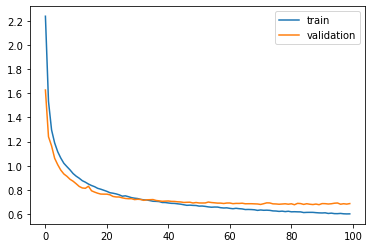

In [21]:
history = model.fit(x_train,y_train,epochs=100,batch_size=1024,validation_split=0.2)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

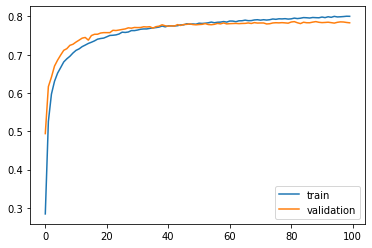

In [22]:
pyplot.plot(history.history['categorical_accuracy'], label='train')
pyplot.plot(history.history['val_categorical_accuracy'], label='validation')
pyplot.legend()
pyplot.show()

In [23]:
model.evaluate(x_test,y_test)

767/767 [==============================] - 5s 6ms/step - loss: 0.6961 - categorical_accuracy: 0.7843


[0.6960575580596924, 0.7842586040496826]

In [24]:
def demo(dem):
  reverse_lang_index = dict(map(reversed, lang_index.items()))
  demo_s = clean_text(dem)
  demo_s = np.array(tokenizer.texts_to_sequences(demo_s))
  demo_s = demo_s.reshape((1,demo_s.shape[0]))
  demo_s = pad_sequences(demo_s, maxlen=76, padding="pre", truncating="post")
  pred = np.around(model.predict(demo_s))
  num = np.argmax(pred)
  langu_age = reverse_lang_index[num]
  return langu_age

In [25]:
demo('How to pause and resume a while loop in Python? I want to have a loop running that will print "Hello" and when I press "K" it stops printing but it does not end the program, then when I press "K" again it starts printing again.')

'python'